In [1]:
import os
import scanpy as sc
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from scipy.sparse import csr_matrix
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
from src.data.spatial_omics_datamodule import SpatialOmicsDataModule
from src.models.bgrl_module import BGRLLitModule
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [2]:
datamodule = SpatialOmicsDataModule(
    data_dir="../data/domain/raw", 
    processed_dir="../data/domain/processed/",
    redo_preprocess=False
    )

datamodule.prepare_data()
datamodule.setup()
test_dataloder = datamodule.test_dataloader()

for batch in test_dataloder:
    print(batch.sample_name[0])
    print(batch.x.shape)

Zhuang-ABCA-4.001
torch.Size([32145, 50])
BaristaSeq1
torch.Size([1512, 50])
MERFISH_small1
torch.Size([5488, 50])
STARmap4
torch.Size([1088, 50])
STARmap2
torch.Size([1049, 50])
STARmap3
torch.Size([1053, 50])
MERFISH_small5
torch.Size([5543, 50])
MERFISH_small4
torch.Size([5803, 50])
STARmap1
torch.Size([1207, 50])
BaristaSeq3
torch.Size([1627, 50])
Zhuang-ABCA-4.003
torch.Size([79997, 50])
MERFISH_small3
torch.Size([5926, 50])
MERFISH_small2
torch.Size([5557, 50])
BaristaSeq2
torch.Size([2017, 50])
Zhuang-ABCA-4.002
torch.Size([50042, 50])


In [5]:
#desired_sample_name = "MERFISH_small5"
desired_sample_name = "Zhuang-ABCA-4.002"
batch = None

for b in test_dataloder:
    if b.sample_name[0] == desired_sample_name:
        batch = b
        break

print(batch)
print(batch.sample_name)

DataBatch(x=[50042, 50], edge_index=[2, 1243572], edge_weight=[1243572], sample_name=[1], batch=[50042], ptr=[2])
['Zhuang-ABCA-4.002']


In [6]:
#checkpoint_path = "../logs/train_domain/runs/2025-03-31_15-41-12/checkpoints/epoch_011.ckpt"
checkpoint_path = "../logs/abca/runs/2025-04-02_17-10-41/checkpoints/epoch_008.ckpt"
model = BGRLLitModule.load_from_checkpoint(checkpoint_path).net.online_encoder
model

/Users/michel/miniconda3/envs/augmentation/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


TwoLayerGCN(
  (conv1): GCNConv(50, 32)
  (conv2): GCNConv(32, 16)
)

In [7]:
with torch.no_grad():
    node_embeddings = model(batch.x, batch.edge_index, batch.edge_weight)
node_embeddings.shape

torch.Size([50042, 16])

In [8]:
adata = sc.read_h5ad(os.path.join("../data/domain/processed/", desired_sample_name + ".h5ad"))
adata

AnnData object with n_obs × n_vars = 50042 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'adj', 'spatial'
    varm: 'PCs'

In [9]:
cell_embeddings_np = node_embeddings.cpu().numpy()
adata.obsm["cell_embeddings"] = cell_embeddings_np
adata

AnnData object with n_obs × n_vars = 50042 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'adj', 'spatial', 'cell_embeddings'
    varm: 'PCs'

In [19]:

sc.pp.neighbors(adata, use_rep="cell_embeddings")
#sc.tl.leiden(adata, resolution=0.11)
#sc.tl.leiden(adata, resolution=0.13)
sc.tl.leiden(adata, resolution=0.131)
print(adata.obs["leiden"])

cell_label
177536119734259275144748435471942472531    3
256532006537596385088807329967308781746    3
28801318882950773770397006451868070066     3
301971869963235435117242882149875853185    3
81203938259029510162263594992098070595     3
                                          ..
170555320258403798366660091820843876518    4
172967519204477533363214380719398743485    7
176865225678328560557322808475537547371    4
291516215723246098248718884197834511549    4
82308047371587414212822326565460966419     4
Name: leiden, Length: 50042, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']


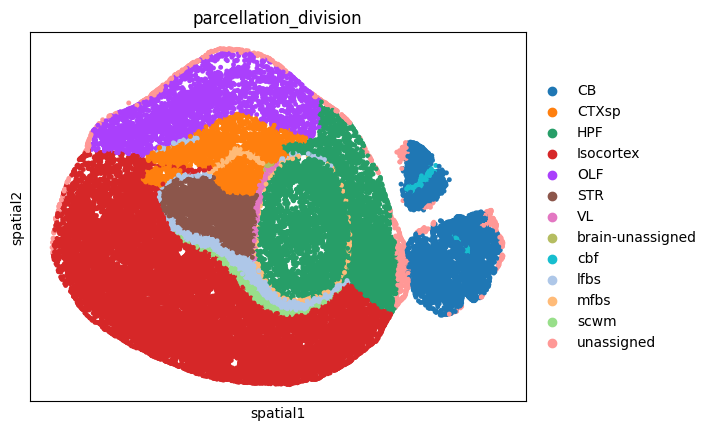

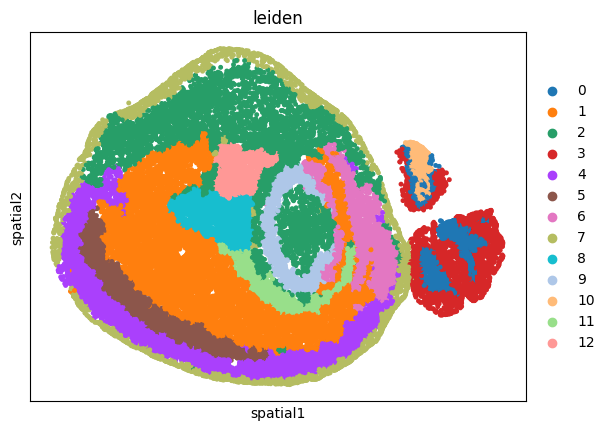

In [20]:
#sc.pl.embedding(adata, basis="spatial", color="Region", size=50)
sc.pl.embedding(adata, basis="spatial", color="parcellation_division", size=50)
sc.pl.embedding(adata, basis="spatial", color="leiden", size=50)

In [21]:
# Ground truth labels
#ground_truth_labels = adata.obs["Region"]
ground_truth_labels = adata.obs["parcellation_division"]

# Leiden clustering labels
leiden_labels = adata.obs["leiden"]

# Compute NMI
nmi = normalized_mutual_info_score(ground_truth_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Compute ARI
ari = adjusted_rand_score(ground_truth_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Normalized Mutual Information (NMI): 0.5880
Adjusted Rand Index (ARI): 0.4296
